Dataset

https://www.dati.lombardia.it/Sanit-/Dataset-SDO-Regione-Lombardia/jv9t-c6q6

https://www.dati.lombardia.it/Sanit-/Dataset-condizioni-di-salute-per-provincia-e-gener/92eu-vwkf

https://www.dati.lombardia.it/Sanit-/Georeferenziazione-strutture/6n7g-5p5e

https://www.dati.lombardia.it/Sanit-/Dataset-Assistenza-Ospedaliera-per-ACC-e-ATS/3rtw-8p48

https://www.dati.lombardia.it/Sanit-/dati-ospedali/avsh-7tmk

##Configurazione

In [ ]:
!pip install sodapy -U -q
!pip install azure-storage-blob -U -q
!pip install selenium
!apt-get update
!pip install SQLAlchemy
!pip install pyodbc
!apt install chromium-chromedriver
!cp /usr/lib/chromium-browser/chromedriver /usr/bin

In [ ]:
%%sh
curl https://packages.microsoft.com/keys/microsoft.asc | apt-key add -
curl https://packages.microsoft.com/config/ubuntu/16.04/prod.list > /etc/apt/sources.list.d/mssql-release.list
sudo apt-get update
sudo ACCEPT_EULA=Y apt-get -q -y install msodbcsql17

In [ ]:
import requests
import numpy as np
import os
import sys
from tqdm import tqdm_notebook as tqdm
import datetime as dt
import warnings
import json
import urllib
import pandas as pd
import urllib.parse
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
sys.path.insert(0,'/usr/lib/chromium-browser/chromedriver')
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
import time
from azure.storage.blob import BlobServiceClient
from sodapy import Socrata
warnings.filterwarnings("ignore")

/usr/local/lib/python3.7/dist-packages/requests/__init__.py:91: RequestsDependencyWarning: urllib3 (1.26.7) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)


In [ ]:
# getting automatic reloading and inline plotting for the entire notebook
%reload_ext autoreload
%autoreload 2
%matplotlib inline
%load_ext google.colab.data_table

## Dataset SDO Regione Lombardia - Source: Azure Blob Storage

In [ ]:
# Create a local directory to hold blob data
current_dir = os.getcwd()
os.mkdir(local_path)
local_path = os.path.join(current_dir,'SDO_regione_lombardia')
os.mkdir(local_path)

In [ ]:
connect_str = 'DefaultEndpointsProtocol=https;AccountName=storagesanita;AccountKey=m+PjppnyYxioaXrB/j9FCiaRezITnlBlwKlzQA1MnAaOgejnCT/aPjIbrFbNRDu7cycT84br51Y1iIaLPfLFyg==;EndpointSuffix=core.windows.net'

In [ ]:
def download_file_from_Azure(local_path,conn_str):

  # Create the BlobServiceClient object which will be used to create a container client
  blob_service_client = BlobServiceClient.from_connection_string(connect_str)
  
  # Create a blob client using the local file name as the name for the blob
  blob_client = blob_service_client.get_blob_client(container='storage-sanita-lombardia',blob='Dataset_SDO_Regione_Lombardia.csv')

  try:
      download_file_path = os.path.join(local_path,'dowload.csv')
      print("\nDownloading blob to \n\t" + download_file_path)
      with open(download_file_path, "wb") as download_file:
        download_file.write(blob_client.download_blob().readall())
  except Exception as e:
      print(e)

In [ ]:
download_file_from_Azure(local_path,conn_str)

## Georeferenziazione strutture - HTTP Open data request

In [ ]:
url = 'https://www.dati.lombardia.it/resource/6n7g-5p5e.json'
response = requests.get(url)
response.status_code

200

In [ ]:
df = pd.DataFrame(json.loads(response.content))
df.head()

,descrizione_struttura_di,ats_struttura,codice_struttura_di_ricovero,indirizzo,cap,localita,coordinata_geografica_x,coordinata_geografica_y,geocoded_column,:@computed_region_ttgh_9sm5,:@computed_region_6hky_swhk,:@computed_region_uypf_y6ry
0,OSPEDALE UBOLDO - CERNUSCO S/NAVIGLIO,321 - ATS DELLA CITTA' METROPOLITANA DI MILANO,030085-00,VIA UBOLDO 21,20063,CERNUSCO SUL NAVIGLIO,45.52331438,9.328467624,"{'latitude': '45.52331438', 'longitude': '9.32...",4,4,8
1,CASA DI CURA BEATO L.TALAMONI-LECCO,324 - ATS DELLA BRIANZA,030033-00,VIA SAN NICOLO' 12,23900,LECCO,45.85685986,9.390429409,"{'latitude': '45.85685986', 'longitude': '9.39...",10,10,5
2,OSPEDALE M. MELLONI - MILANO,321 - ATS DELLA CITTA' METROPOLITANA DI MILANO,030057-00,VIA MACEDONIO MELLONI 52,20129,MILANO,45.4666791,9.219506903,"{'latitude': '45.4666791', 'longitude': '9.219...",4,4,8
3,CASA DI CURA SANTA MARIA - CASTELLANZA,322 - ATS DELL'INSUBRIA,030015-00,"VIALE PIEMONTE, 70",21053,CASTELLANZA,45.5994841,8.87237785,"{'latitude': '45.5994841', 'longitude': '8.872...",1,1,3
4,OSPEDALE MORELLI - SONDALO,323 - ATS DELLA MONTAGNA,030904-00,VIA ZUBIANI 33,23039,SONDALO,46.33431031,10.32968894,"{'latitude': '46.33431031', 'longitude': '10.3...",3,3,7


## Dataset condizioni di salute per provincia -Web Scraping with Selenium

In [ ]:
chrome_options = webdriver.ChromeOptions()
chrome_options.add_argument('--headless')
chrome_options.add_argument('--no-sandbox')
chrome_options.add_argument('--disable-dev-shm-usage')

In [ ]:
linkweb = 'https://www.dati.lombardia.it/Sanit-/Dataset-condizioni-di-salute-per-provincia-e-gener/92eu-vwkf'
scrWidth = 1920
scrHeight = 1080
delay = 10

In [ ]:
def webpage_shot():
    wd.save_screenshot('screenshot.png')
    %pylab inline
    img=mpimg.imread('/content/screenshot.png')
    imgplot = plt.imshow(img)
    print(wd.title)
    return plt.show()

In [ ]:
wd = webdriver.Chrome('chromedriver',chrome_options=chrome_options)
wd.set_window_size(scrWidth, scrHeight)
wd.get(linkweb)

Populating the interactive namespace from numpy and matplotlib
Dataset condizioni di salute per provincia e genere | Open Data Regione Lombardia


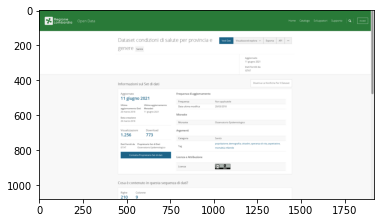

In [ ]:
webpage_shot()

In [ ]:
def extract_table_values(row):
  anno = ""
  provincia = ""
  genere = ""
  coordinata_x = ""
  coordinata_y = ""
  speranza_vita_nascita = ""
  tasso_mortalita = ""
  tasso_mortalita_infantile = ""
  posizione = ""
  tms_loading = dt.datetime.now()

  elm = row.split("\n")

  try:
    anno = elm[0]
    provincia = elm[1]
    genere = elm[2]
    coordinata_x = elm[3]
    coordinata_y = elm[4]
    speranza_vita_nascita = elm[5]
    tasso_mortalita = elm[6]
    tasso_mortalita_infantile = elm[7]
    posizione = elm[8]        
  except:
    pass
  return {'tms_loading': tms_loading,
          'anno': anno,
          'provincia': provincia,
          'genere': genere,
          'coordinata_x': coordinata_x,
          'coordinata_y': coordinata_y,
          'speranza_vita_nascita': speranza_vita_nascita,
          'tasso_mortalita': tasso_mortalita,
          'tasso_mortalita_infantile': tasso_mortalita_infantile,
          'posizione':posizione
          }

In [ ]:
rows_to_scrape = wd.find_element_by_css_selector('div > div > dl > div:nth-child(1) > dd')
num_rows = int(rows_to_scrape.text)
print('Total rows to scrape: ' + str(num_rows)) 

Total rows to scrape: 210


In [ ]:
dataset_condizioni_salute_prov = []

num_pages = math.ceil(num_rows/13)

for num in tqdm(range(1,num_pages + 1)):
  table_socr = wd.find_element_by_css_selector("div.socrata-visualization-chart-container > div > table > tbody")
  t_cond_salute = table_socr.find_elements_by_tag_name("tr")
  for s in t_cond_salute:
    dataset_condizioni_salute_prov.append(extract_table_values(s.text))
  WebDriverWait(wd, delay).until(EC.element_to_be_clickable((By.CLASS_NAME, "pager-button-next")))

  0%|          | 0/17 [00:00<?, ?it/s]

In [ ]:
df_condizioni_salute_prov = pd.DataFrame(dataset_condizioni_salute_prov)
df_condizioni_salute_prov.head()

,tms_loading,anno,provincia,genere,coordinata_x,coordinata_y,speranza_vita_nascita,tasso_mortalita,tasso_mortalita_infantile,posizione
0,2021-11-07 22:57:05.587387,2012,BERGAMO,F,"9,63853045","45,68012929","84,5","8,381804761882657","3,73","(45.68012929°, 9.63853045°)"
1,2021-11-07 22:57:05.610041,2012,BRESCIA,F,"10,18167955","45,51939749",85,"8,654399715669228","4,1","(45.51939749°, 10.18167955°)"
2,2021-11-07 22:57:05.633095,2012,COMO,F,"9,039360974","45,80216962","85,7","9,290944196983311","3,85","(45.80216962°, 9.039360974°)"
3,2021-11-07 22:57:05.655742,2012,CREMONA,F,"10,0131151","45,13644491",84,"10,691872186630041","1,84","(45.13644491°, 10.0131151°)"
4,2021-11-07 22:57:05.678526,2012,ITALIA,F,"84,4","10,24902789486484","3,15",,,


In [ ]:
wd.close()

## Dataset assistenza ospedaliera - Source: API Socrata

In [ ]:
data_url = 'dati.lombardia.it'                        # The Host Name for the API endpoint (the https:// part will be added automatically)
data_set = '3rtw-8p48'                                # The data set at the API endpoint
app_token = os.getenv('qEei2HKE5SldzRBJyNJqp9Wjw')    # The app token
limit_rows = 100000

In [ ]:
client = Socrata(data_url,app_token)
# Set the timeout to 60 seconds    
client.timeout = 60
# The SoDaPy library converts this CSV object to a Python list of dictionaries
results = client.get(data_set,limit=limit_rows)
# Convert the list of dictionaries to a Pandas data frame
df_hospital_assistance = pd.DataFrame.from_records(results)

In [ ]:
df_hospital_assistance.head()

,anno,codice_ats_residenza,descrizione_ats_residenza,coordinata_geografica_x,coordinata_geografica_y,posizione_ats,codice_acc_di_diagnosi,descrizione_acc_di_diagnosi,tasso_ricoveri_stessa_ats,tasso_ricoveri_altra_ats,:@computed_region_ttgh_9sm5,:@computed_region_6hky_swhk,:@computed_region_af5v_nc64
0,2014,324,ATS DELLA BRIANZA,9.298423314,45.69919245,"{'type': 'Point', 'coordinates': [9.298423314,...",128,ASMA,0.0,0.36892458483520535,10,10,5
1,2013,323,ATS DELLA MONTAGNA,10.32968894,46.33431031,"{'type': 'Point', 'coordinates': [10.32968894,...",4,MICOSI,0.0,0.035604716438104166,3,3,7
2,2015,325,ATS DI BERGAMO,9.63853045,45.68701679,"{'type': 'Point', 'coordinates': [9.63853045, ...",88,GLAUCOMA,0.0,0.11092543375902847,5,5,1
3,2015,326,ATS DI BRESCIA,10.25368782,45.65171815,"{'type': 'Point', 'coordinates': [10.25368782,...",39,LEUCEMIE,0.0,0.17010908459834068,6,6,2
4,2012,325,ATS DI BERGAMO,9.63853045,45.68701679,"{'type': 'Point', 'coordinates': [9.63853045, ...",123,INFLUENZA,0.0,0.0174810698414743,5,5,1


## Performance degli Ospedali - Source: Azure SQL Database

In [ ]:
server = "airadav-work.database.windows.net"
database = "hospitalization-lombardy"
username = "admindav"
password = "Password01"

driver = '{ODBC Driver 17 for SQL Server}'

odbc_str = 'DRIVER='+driver+';SERVER='+server+';PORT=1433;UID='+username+';DATABASE='+ database + ';PWD='+ password
connect_str = 'mssql+pyodbc:///?odbc_connect=' + urllib.parse.quote(odbc_str)

engine = create_engine(connect_str)

df_performance_hospital = pd.read_sql_query("SELECT * FROM dbo.WRH_PERFORMANCE_HOSPITAL",con=engine)

engine.dispose()

In [ ]:
df_performance_hospital.head()

,PERIODO,CODICE_STRUTTURA,DENOMINAZIONE_STRUTTURA,NUM_TOTALE_RICOVERI,NUM_DIMISSIONI_VOLONTARIE,NUM_TOTALE_DIMISSIONI,NUM_TRASFERIMENTI_FRA_STRUTTURE,NUM_RICOVERI_RIPETUTI,NUM_RITORNI_IN_SALA_OPERATORIA,NUM_DI_RICOVERI_DI_TIPO_CHIRURGICO
0,2010,030004-00,OSPEDALE DI CIRCOLO - BUSTO ARSIZIO,23103,38,8348,22,862,49.0,3706
1,2010,030006-00,OSP. S. ANTONIO ABATE - GALLARATE,18719,83,7416,55,566,30.0,2662
2,2010,030008-00,OSP. GENERALE PROVINCIALE - SARONNO,15559,71,7006,24,645,50.0,2501
3,2010,030009-00,OSP. CIRCOLO A.BELLINI - SOMMA LOMBARDO,2858,14,1012,4,35,0.0,2
4,2010,030010-00,OSPEDALE DI CIRCOLO GALMARINI - TRADATE,10640,22,4124,18,326,11.0,2049
